# Анализ выбора портфеля по коэффициенту Шарпа жадным алгоритмом

In [19]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

Считываем данные

In [3]:
start = datetime.now()
data = pd.read_csv("Россия 37 Акций 2016-01.07.2019.txt")
data = np.array(data)
periods_in_data = data.shape[0]
print(periods_in_data)

881


In [4]:
print(data)

[[ 2.01601040e+07 -1.52180400e+00 -1.52155153e+00 ... -2.70986745e+00
   4.71380471e-01  1.11663653e+01]
 [ 2.01601050e+07  3.02138343e+00  1.12824001e+00 ...  3.70874962e+00
   2.37935657e+00  1.12647418e+01]
 [ 2.01601060e+07 -8.40336134e-02 -3.16966245e-01 ... -1.16771274e+00
  -5.72831424e-01  3.80116959e+00]
 ...
 [ 2.01906270e+07  4.01231688e-01  1.62874666e-01 ...  6.00200067e-01
   1.16510655e+00  1.03524229e+00]
 [ 2.01906280e+07 -1.39405204e+00 -4.96823352e-01 ... -4.97182632e-01
  -3.34678610e-01 -1.26444299e+00]
 [ 2.01907010e+07  1.38548539e+00  1.28785003e+00 ...  4.16389074e-01
  -6.81481481e-01  3.86398764e+00]]


In [30]:
data = np.delete(data, 0, axis = 1)
#data = np.delete(data, 0, axis = 1)  # Удалять дополительно второй столбец только в часовых котировках

stocks_to_portf_min = 5
stocks_to_portf_max = 6
stocks_to_portf_step = 1

sharp_period_min = 20
sharp_period_max = 320
sharp_period_step = 20

hold_period_min = 10       # Важна кратность диапазона end-start по hold(step)
hold_period_max = 190
hold_period_step = 10

sharp_period = 125
start_of_test_period = sharp_period_max
end_of_test_period = periods_in_data // hold_period_max * hold_period_max

mean_annual_profit_overal = []
P_L_overal = []
random_income_overal = []
random_portf_list = []
# Рассматриваем разное количество акций в портфеле по Кэф Шарпа
for stocks_to_portf in range(stocks_to_portf_min, stocks_to_portf_max, stocks_to_portf_step):
    # Рассматриваем разный период рассчета Кэф Шарпа.
    for sharp_period in range(sharp_period_min,sharp_period_max,sharp_period_step):
        #Смотрим также результаты стратегии Купи и держи в те же периоды.
        P_L_by_hold = []
        mean_annual_profit_by_hold = []
        random_income_hold = []
        for hold in range(hold_period_min,hold_period_max,hold_period_step):
            start_of_test_period = sharp_period_max # Должен быть больше чем sharp_period
            columns_count = data.shape[1] # число акций
            stocks_to_portf_list = []
            overal_results = []
            random_portf_list = []
            
            for i in range(start_of_test_period,end_of_test_period,hold): # Пересчитываем через период hold коэфф Шарпа
                stocks_to_portf_list = []          
                counter = 1
                random_portf = np.mean(np.array(data[i-sharp_period:i,:]))
                random_array = np.array(data[i-sharp_period:i,:])
                random_portf_list.append(random_portf)
                for k in range(0, stocks_to_portf):
                    sharp_ratio_list = []
                    if counter == 1:                             # Выбираем первую акцию в портфель
                        for j in range(0, columns_count):
                            share_prices = np.array(data[i-sharp_period:i,j], dtype=float)
                            income = np.sum(share_prices)
                            std = np.std(share_prices)
                            if std > 0 and income > 0:
                                sharp_ratio = income/std
                            else:
                                sharp_ratio = 0
                            sharp_ratio_list.append(sharp_ratio)
                        
                        max_sharp_ratio = max(sharp_ratio_list)
                        indx_max_sharp_ratio = np.argmax(sharp_ratio_list)
                        comulative_income = np.array(data[i-sharp_period:i,indx_max_sharp_ratio], dtype=float)   # Инициализируем доход портфеля
                        stocks_to_portf_list.append(indx_max_sharp_ratio)
                        counter = counter + 1
                    else:
                        for j in range(0, columns_count):
                            if j in stocks_to_portf_list:    # Чтобы не включать акцию повторно
                                sharp_ratio_list.append(0)
                            else:
                                share_prices = np.array(data[i-sharp_period:i,j], dtype=float)
                                sub_sumpl_comulative_income = comulative_income + share_prices 
                                income = np.sum(sub_sumpl_comulative_income)
                                std = np.std(sub_sumpl_comulative_income)
                                if std > 0 and income > 0:
                                    sharp_ratio = income/std
                                else:
                                    sharp_ratio = 0
                                sharp_ratio_list.append(sharp_ratio)
                        
                        max_sharp_ratio = max(sharp_ratio_list)
                        indx_max_sharp_ratio = np.argmax(sharp_ratio_list)
                        comulative_income = comulative_income + np.array(data[i-sharp_period:i,indx_max_sharp_ratio], dtype=float)
                        stocks_to_portf_list.append(indx_max_sharp_ratio)
                        counter = counter + 1
                
                stocks_to_portf_list = np.array(stocks_to_portf_list)
                for j in range(0,stocks_to_portf):
                    if j == 0:
                        stock_ind = stocks_to_portf_list[j]
                        results = np.array(data[i:i+hold,stock_ind])#, dtype=float)
                    else:
                        stock_ind = stocks_to_portf_list[j]
                        results = results + np.array(data[i:i+hold,stock_ind])#, dtype=float)
                results = np.array(results)        
                overal_results.append(results)
            
            overal_results = np.array(overal_results)    
            
            # Анализируем результаты
            strings = overal_results.shape[0]
            rows  = overal_results.shape[1]
            
            mean_profit_list = []
            P_L_list = []
            
            for i in range(0, overal_results.shape[0]):
                profit = 0
                loss = 0
                for j in range(0, overal_results.shape[1]):
                    if overal_results[i][j] >= 0:
                        profit = profit + overal_results[i][j]
                    else:
                        loss = loss + overal_results[i][j]
                        
                mean_profit = (profit + loss)/stocks_to_portf
                P_L = -profit / loss
                mean_profit_list.append(mean_profit)
                P_L_list.append(P_L)
            
            mean_profit_list = np.array(mean_profit_list)
            P_L_list = np.array(P_L_list)
            random_portf_list = np.array(random_portf_list)
            
            mean_annual_profit = mean_profit_list.mean()*(250 / hold)     # Менять когда час 2250 или День 250 
            P_L = P_L_list.mean()
            random_income = random_portf_list.mean() * 250              # Менять когда час 2250 или День 250
            
            mean_annual_profit_by_hold.append(mean_annual_profit)
            P_L_by_hold.append(P_L)
            random_income_hold.append(random_income)
            
            #print('mean_annual_profit_by_hold:', mean_annual_profit_by_hold)
            #print('P_L_list.mean:', P_L)
            #print('random_portf_mean_profit:', random_income)
            
        
        mean_annual_profit_by_hold = np.array(mean_annual_profit_by_hold)
        P_L_by_hold = np.array(P_L_by_hold)
        random_income_hold = np.array(random_income_hold)
        
        mean_annual_profit_overal.append(mean_annual_profit_by_hold)
        P_L_overal.append(P_L_by_hold)
        random_income_overal.append(random_income_hold)
            
#mean_annual_profit_overal = np.array(mean_annual_profit_overal)       
#P_L_overal = np.array(P_L_overal)
#random_income_overal = np.array(random_income_overal)  

hold_periods = range(hold_period_min, hold_period_max, hold_period_step)
sharp_periods = range(sharp_period_min, sharp_period_max, sharp_period_step)

mean_annual_profit_overal = pd.DataFrame(mean_annual_profit_overal)
P_L_overal = pd.DataFrame(P_L_overal)
random_income_overal = pd.DataFrame(random_income_overal)
                                        
mean_annual_profit_overal.columns = hold_periods
P_L_overal.columns = hold_periods
random_income_overal.columns = hold_periods

#mean_annual_profit_overal.insert(0, 'sharp_periods', sharp_periods)
#P_L_overal.insert(0, 'sharp_periods', sharp_periods)
#random_income_overal.insert(0, 'sharp_periods', sharp_periods)

#print(mean_annual_profit_overal)
#print(P_L_overal)
#print(random_income_overal)

finish = datetime.now()
time_consumed = finish - start
print('start:', start)
print('finish:', finish)
print('time_consumed:', time_consumed)

#random_max_list = []
#random_min_list = []
#for i in range(0,random_array.shape[0]):
#    random_max_list.append(np.max(random_array[i,:]))
#    random_min_list.append(np.min(random_array[i,:]))
#
#print('random_max_list:', random_max_list)
#print('random_min_list:', random_min_list)

C:\Users\user\AppData\Local\Temp\ipykernel_6568\431183012.py:114: RuntimeWarning: divide by zero encountered in double_scalars
  P_L = -profit / loss


start: 2023-02-08 16:09:36.233615
finish: 2023-02-08 17:51:24.427234
time_consumed: 1:41:48.193619


<AxesSubplot:>

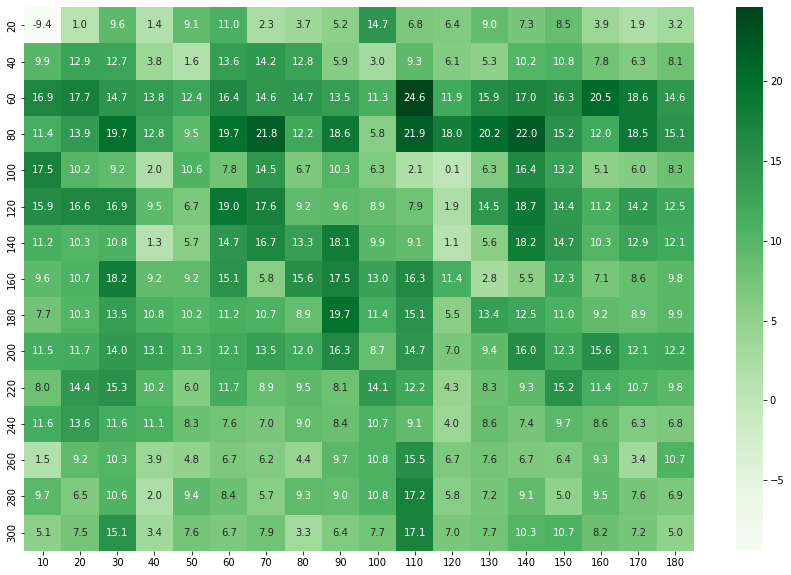

In [29]:
plt.rcParams['figure.figsize'] = 15, 10
sns.heatmap(mean_annual_profit_overal, annot=True, fmt=".1f", xticklabels = True,
            yticklabels = sharp_periods, cmap="Greens")

<AxesSubplot:>

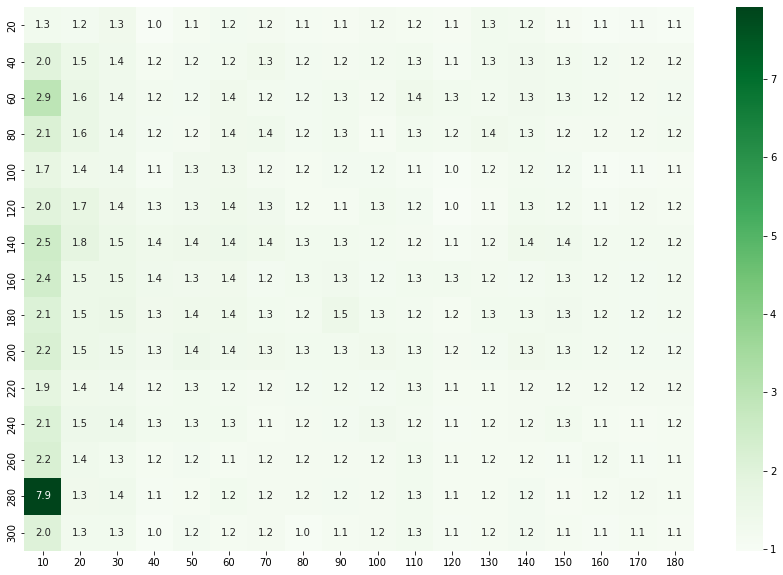

In [24]:
plt.rcParams['figure.figsize'] = 15, 10
sns.heatmap(P_L_overal, annot=True, fmt=".1f", xticklabels = True,
            yticklabels = sharp_periods, cmap="Greens")

<AxesSubplot:>

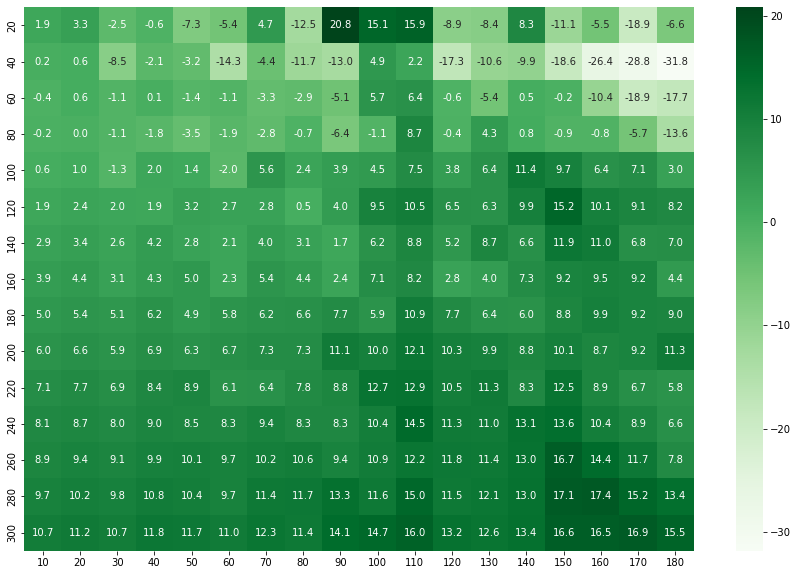

In [25]:
plt.rcParams['figure.figsize'] = 15, 10
sns.heatmap(random_income_overal, annot=True, fmt=".1f", xticklabels = True,
            yticklabels = sharp_periods, cmap="Greens")